In [1]:
!pip install gymnasium[toy-text]

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     --------------------------------------- 10.4/10.4 MB 32.8 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.1.0
    Uninstalling pygame-2.1.0:
      Successfully uninstalled pygame-2.1.0


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'F:\\Fajri\\Anaconda\\envs\\gpu2\\Lib\\site-packages\\~ygame\\base.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [2]:
import time
import random
import numpy as np
import gymnasium as gym

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import geom

is_ipython = "inline" in plt.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

In [3]:
env = gym.make("FrozenLake-v1", map_name="8x8", render_mode="rgb_array", is_slippery=False)

print(f"OBSERVATON SPACE: {env.observation_space}")
print(f"ACTION SPACE: {env.action_space}")

OBSERVATON SPACE: Discrete(64)
ACTION SPACE: Discrete(4)


Initial observation:


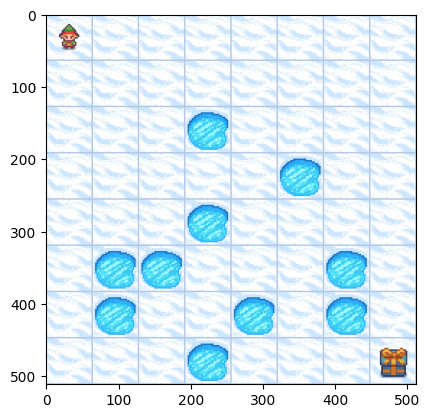

In [4]:
print("Initial observation:")
env.reset()
plt.imshow(env.render());

### 0. Random walk

Is it posible to reach goal just by random walk? 

What is the probability of success and how many attempts are needed.

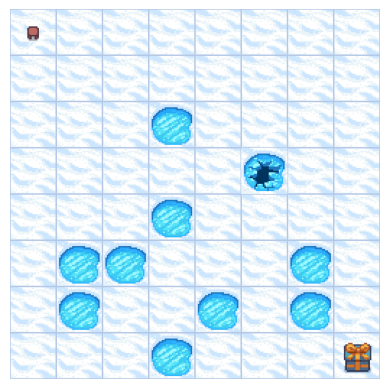

In [5]:
# One simulation

env = gym.make("FrozenLake-v1", map_name="8x8", render_mode="rgb_array", is_slippery=False)

state, info = env.reset()
img = plt.imshow(env.render())
while True:
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)
    img.set_data(env.render()) 
    plt.axis("off")
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if terminated:
            break
    time.sleep(.1)

#### How many attempts are needed before the first success?

There are a number of ways to estimate the success probabilities in a simulation:
* run a lot of simulations and calculate the ratio of the number of successes to the number of failures.
* run simulations up to a given number of successes and estimate the probability of success by the method of moments as the reciprocal of the average number of failures to success (because this is a geometric distribution).

The second approach is preferable because it allows more accurate estimates of the confidence and tolerance intervals for p.

In [6]:
N = 1000  # Required number of successes

counter = 0
n_to_success = []

env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
state, info = env.reset()

while True:
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)
    if terminated:
        counter+=1
        if reward > 0:
            n_to_success.append(counter)
            counter = 0
            if len(n_to_success) == N:
                break
        env.reset()

n_to_success - sample from a geometric distribution.

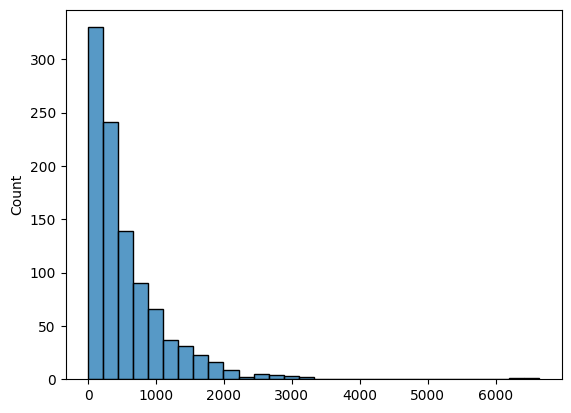

In [7]:
sns.histplot(n_to_success, bins=30);

In [8]:
p = 1/np.mean(n_to_success)
print(f"p = {p:.5f}")

p = 0.00179


$z = \cfrac{\overline{x} - 1/p}{\sqrt{(1-p)/(np^2)}}$

We need to find the p by solving this equation.

In [9]:
def geom_pCI(lst):
    mean = np.mean(lst)
    n = len(lst)
    z = 1.96

    A = mean**2
    B = (z**2/n - 2*mean)
    C = (1 - z**2/n)

    D = B**2 - 4*A*C
    
    return (-B - D**.5) / 2/ A, (-B + D**.5) / 2/ A

In [10]:
pl, ph = geom_pCI(n_to_success)

print(f"95%CI for p = [{pl:.5f}, {ph:.5f}]")

95%CI for p = [0.00168, 0.00190]


To estimate the minimum number of simulations required to achieve success with a probability of 95%, we use the lower estimate of the probability of success in one trial.

In [11]:
n_attempts = geom.ppf(0.95, pl, loc=0)
n_attempts

1781.0

Result check:

In [12]:
print(f"Percentage of attempts exceeding {n_attempts} - {np.mean(np.array(n_to_success) > n_attempts)*100:.2f}%")

Percentage of attempts exceeding 1781.0 - 4.20%


Visual comparison of histograms:

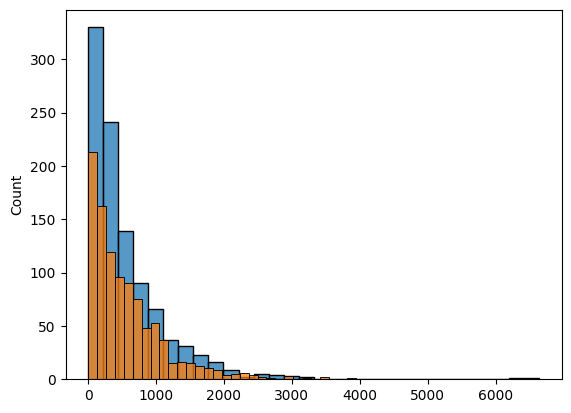

In [13]:
sns.histplot(n_to_success, bins=30);
sns.histplot(geom.rvs(p, size=1000), bins=30);

#### 1. Q-learning

In [14]:
def greedy_policy(Qtable, state):
    # action = np.argmax(Qtable[state][:])
    action = np.random.choice(np.where(Qtable[state] == Qtable[state].max())[0])
    
    return action

def epsilon_greedy_policy(Qtable, state, epsilon, env):
    random_int = random.uniform(0, 1)
    
    if random_int > epsilon:
        action = greedy_policy(Qtable, state)
    else:
        action = env.action_space.sample()

    return action

def initialize_q_table(state_space, action_space):
    Qtable = np.zeros((state_space, action_space))
    return Qtable

def get_epsilon(i, min_epsilon, max_epsilon, decay_rate):
    return min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * i)

def evaluate(env, Q, n_eval_episodes=100, max_steps=100):
    obs_visited = np.zeros(Q.shape[0])
    episode_rewards = []

    for episode in tqdm(range(n_eval_episodes)):
        route = np.zeros(Q.shape[0])
        
        state, _ = env.reset()
        route[state] = 1

        for _ in range(max_steps):
            action = greedy_policy(Q, state)
            new_state, reward, terminated, truncated, _ = env.step(action)
            route[new_state] = 1

            if terminated or truncated:
                episode_rewards.append(reward)
                obs_visited += route
                break
            state = new_state

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return obs_visited, mean_reward, std_reward

def plot_Qtable(Qtable, visits):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    shw1 = axs[0].imshow(Qtable.mean(1).reshape(8,8), cmap="GnBu")
    plt.colorbar(shw1, ax=axs[0])
    axs[0].title.set_text("mean Q_value")

    shw2 = axs[1].imshow(visits.sum(1).reshape(8,8), cmap="GnBu")
    plt.colorbar(shw2, ax=axs[1])
    axs[1].title.set_text("count of visits")

def plot_learning_curves(delta_log, ep_len_log):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    sns.lineplot(delta_log, ax=axs[0])
    axs[0].set_ylabel("Mean ep delta")
    axs[0].set_xlabel("Episode")

    sns.lineplot(ep_len_log, ax=axs[1])
    axs[1].set_ylabel("Episode length")
    axs[1].set_xlabel("Episode");

def one_episode_preview(Qtable):
    env = gym.make("FrozenLake-v1", map_name="8x8", render_mode="rgb_array", is_slippery=False)

    state, info = env.reset()
    img = plt.imshow(env.render())
    for _ in range(100):
        action = greedy_policy(Qtable, state)
        state, _, terminated, _, _ = env.step(action)
        img.set_data(env.render()) 
        plt.axis("off")
        display.display(plt.gcf())
        display.clear_output(wait=True)
        if terminated:
                break
        time.sleep(.1)

#### 2. Monte Carlo Learning

In [15]:
n_training_episodes = 15000
n_eval_episodes = 100

max_steps = 100  # per 1 episode
gamma = 0.9

max_epsilon = 1.0
min_epsilon = 0.1
decay_rate = 15/n_training_episodes

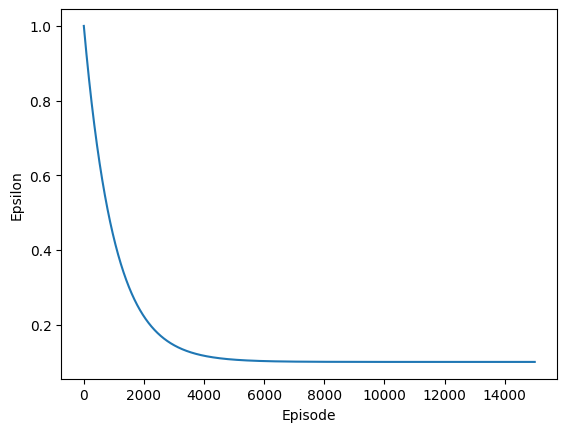

In [16]:
plt.plot([get_epsilon(ep, min_epsilon, max_epsilon, decay_rate) for ep in range(n_training_episodes)]);
plt.ylabel("Epsilon")
plt.xlabel("Episode");

In [17]:
def MC_train(n_training_episodes, env, max_steps, Qtable):
    Qtable = np.copy(Qtable)
    visits = np.zeros_like(Qtable)
    
    delta_log = []
    ep_len_log = []

    for episode in tqdm(range(n_training_episodes)):
        episode_delta_log = []
        
        epsilon = get_epsilon(episode, min_epsilon, max_epsilon, decay_rate)
        ep_seq = []

        state, _ = env.reset()
        for _ in range(max_steps):
            action = epsilon_greedy_policy(Qtable, state, epsilon, env)

            new_state, reward, terminated, truncated, _ = env.step(action)
            ep_seq.append((state, action, reward))
            
            if terminated or truncated:
                ep_len_log.append(len(ep_seq))
                visited_s = set()
                for i, (s, a, r) in enumerate(ep_seq):
                    Gt = reward*gamma**(len(ep_seq) - i - 1)
                    if s not in visited_s:
                        visited_s.add(s)
                        visits[s][a] += 1
                        episode_delta_log.append(abs(Gt - Qtable[s][a]))
                        Qtable[s][a] = Qtable[s][a] + (Gt - Qtable[s][a]) / visits[s][a]
                break
            state = new_state

        delta_log.append(np.mean(episode_delta_log))
    return Qtable, delta_log, visits, ep_len_log

In [18]:
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)

state_space = env.observation_space.n
action_space = env.action_space.n

Qtable = initialize_q_table(state_space, action_space)

In [19]:
Qtable, MC_delta_log, visits, MC_ep_len_log = MC_train(n_training_episodes, env, max_steps, Qtable)

  0%|          | 0/15000 [00:00<?, ?it/s]

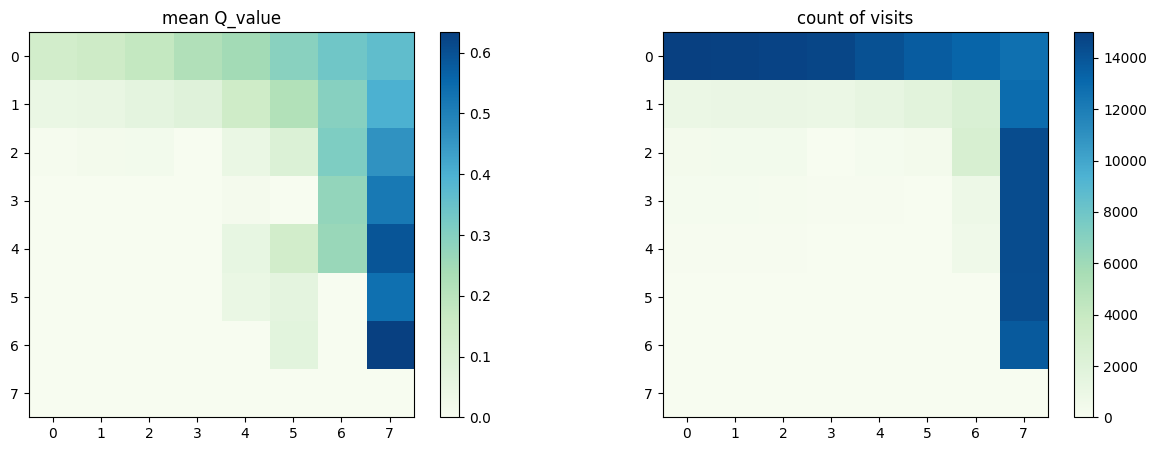

In [20]:
plot_Qtable(Qtable, visits)

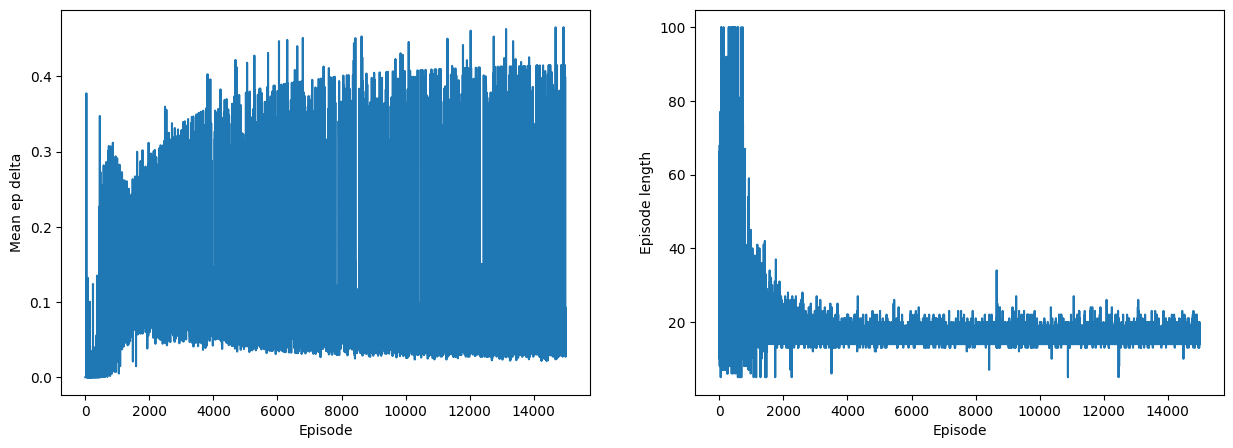

In [21]:
plot_learning_curves(MC_delta_log, MC_ep_len_log)

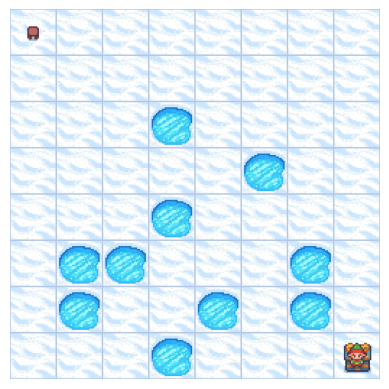

In [22]:
one_episode_preview(Qtable)

In [23]:
visited, m, std = evaluate(env, Qtable)

print(f"mean_reward = {m}, std_reward = {std}")

  0%|          | 0/100 [00:00<?, ?it/s]

mean_reward = 1.0, std_reward = 0.0


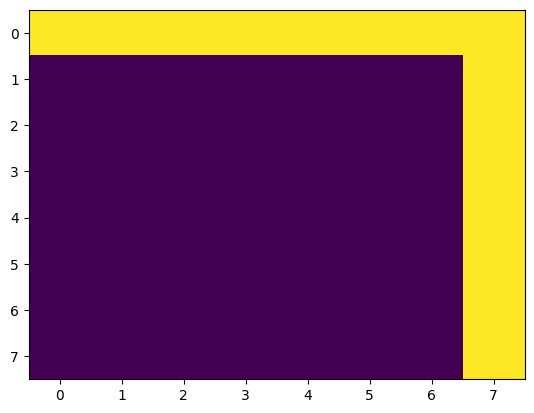

In [24]:
plt.imshow(visited.reshape(8, 8), aspect="auto")

#### 3. Temporal Difference Learning

In [25]:
n_training_episodes = 10000
n_eval_episodes = 100

learning_rate = 0.7

max_steps = 2000  # per episode
gamma = 0.9

max_epsilon = 1.0
min_epsilon = 0.5
decay_rate = 10/n_training_episodes

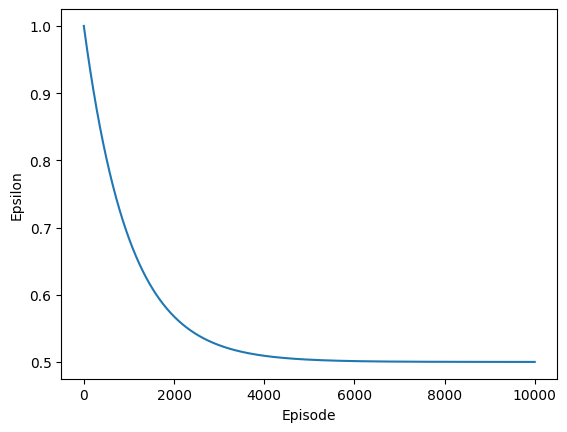

In [26]:
plt.plot([get_epsilon(ep, min_epsilon, max_epsilon, decay_rate) for ep in range(n_training_episodes)]);
plt.ylabel("Epsilon")
plt.xlabel("Episode");

In [27]:
def TD_train(n_training_episodes, env, max_steps, Qtable):
    Qtable = np.copy(Qtable)
    visits = np.zeros_like(Qtable)
    
    delta_log = []
    ep_len_log = []

    for episode in tqdm(range(n_training_episodes)):
        episode_delta_log = []

        epsilon = get_epsilon(episode, min_epsilon, max_epsilon, decay_rate)
        
        state, _ = env.reset()
        for si in range(max_steps):
            action = epsilon_greedy_policy(Qtable, state, epsilon, env)

            new_state, reward, terminated, truncated, _ = env.step(action)

            TD = reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action]
            episode_delta_log.append(TD)

            Qtable[state][action] = Qtable[state][action] + learning_rate * TD
            visits[state][action] += 1
            if terminated or truncated:
                ep_len_log.append(si)
                break

            state = new_state

        delta_log.append(np.mean(episode_delta_log))
    return Qtable, delta_log, visits, ep_len_log

In [28]:
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)

state_space = env.observation_space.n
action_space = env.action_space.n

Qtable = initialize_q_table(state_space, action_space)

In [29]:
Qtable, TD_delta_log, visits, TD_ep_len_log = TD_train(n_training_episodes, env, max_steps, Qtable)

  0%|          | 0/10000 [00:00<?, ?it/s]

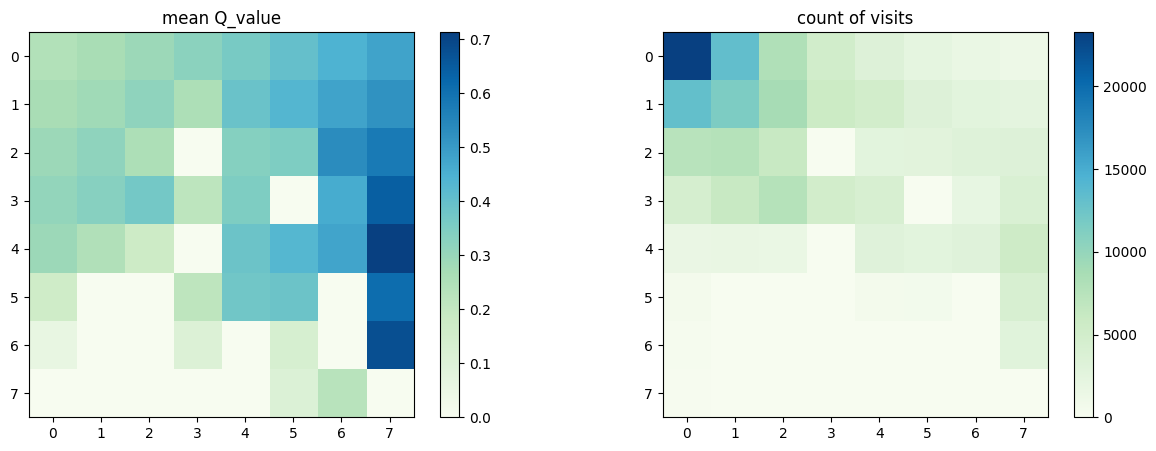

In [30]:
plot_Qtable(Qtable, visits)

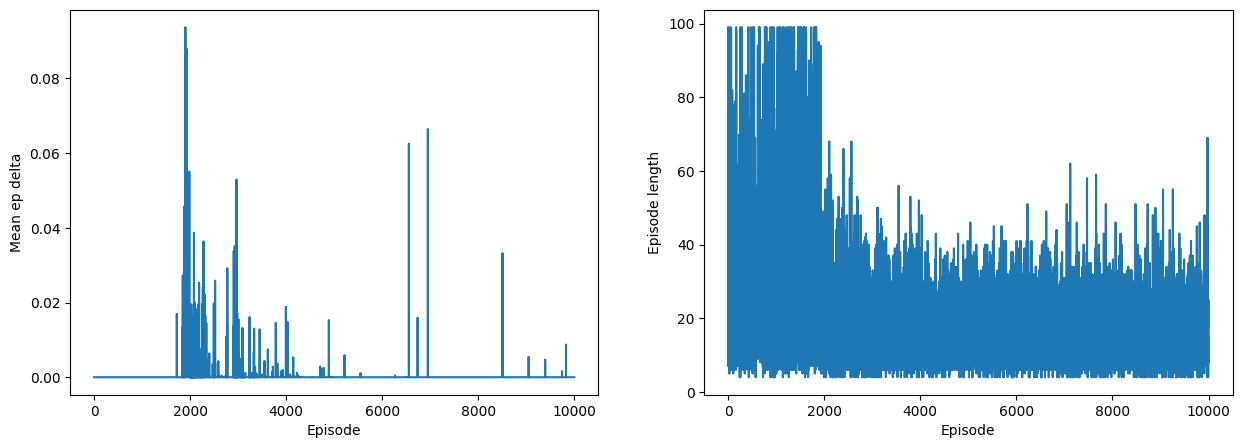

In [31]:
plot_learning_curves(TD_delta_log, TD_ep_len_log)

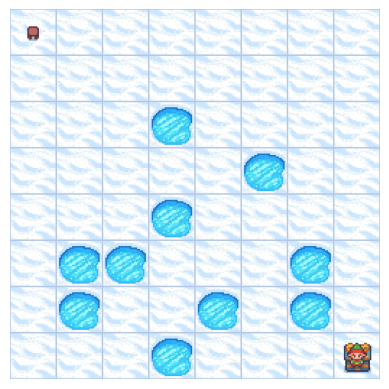

In [32]:
env = gym.make("FrozenLake-v1", map_name="8x8", render_mode="rgb_array", is_slippery=False)

state, info = env.reset()
img = plt.imshow(env.render())
for _ in range(max_steps):
    action = greedy_policy(Qtable, state)
    state, reward, terminated, truncated, info = env.step(action)
    img.set_data(env.render()) 
    plt.axis("off")
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if terminated:
            break
    time.sleep(.1)

In [33]:
visited, m, std = evaluate(env, Qtable)

print(m, std)

  0%|          | 0/100 [00:00<?, ?it/s]

1.0 0.0


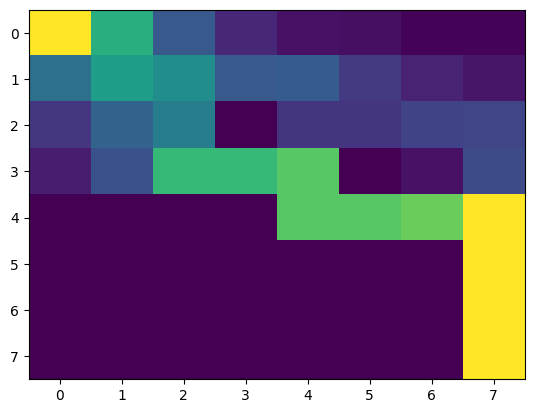

: 

In [34]:
plt.imshow(visited.reshape(8, 8), aspect="auto")